<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                 

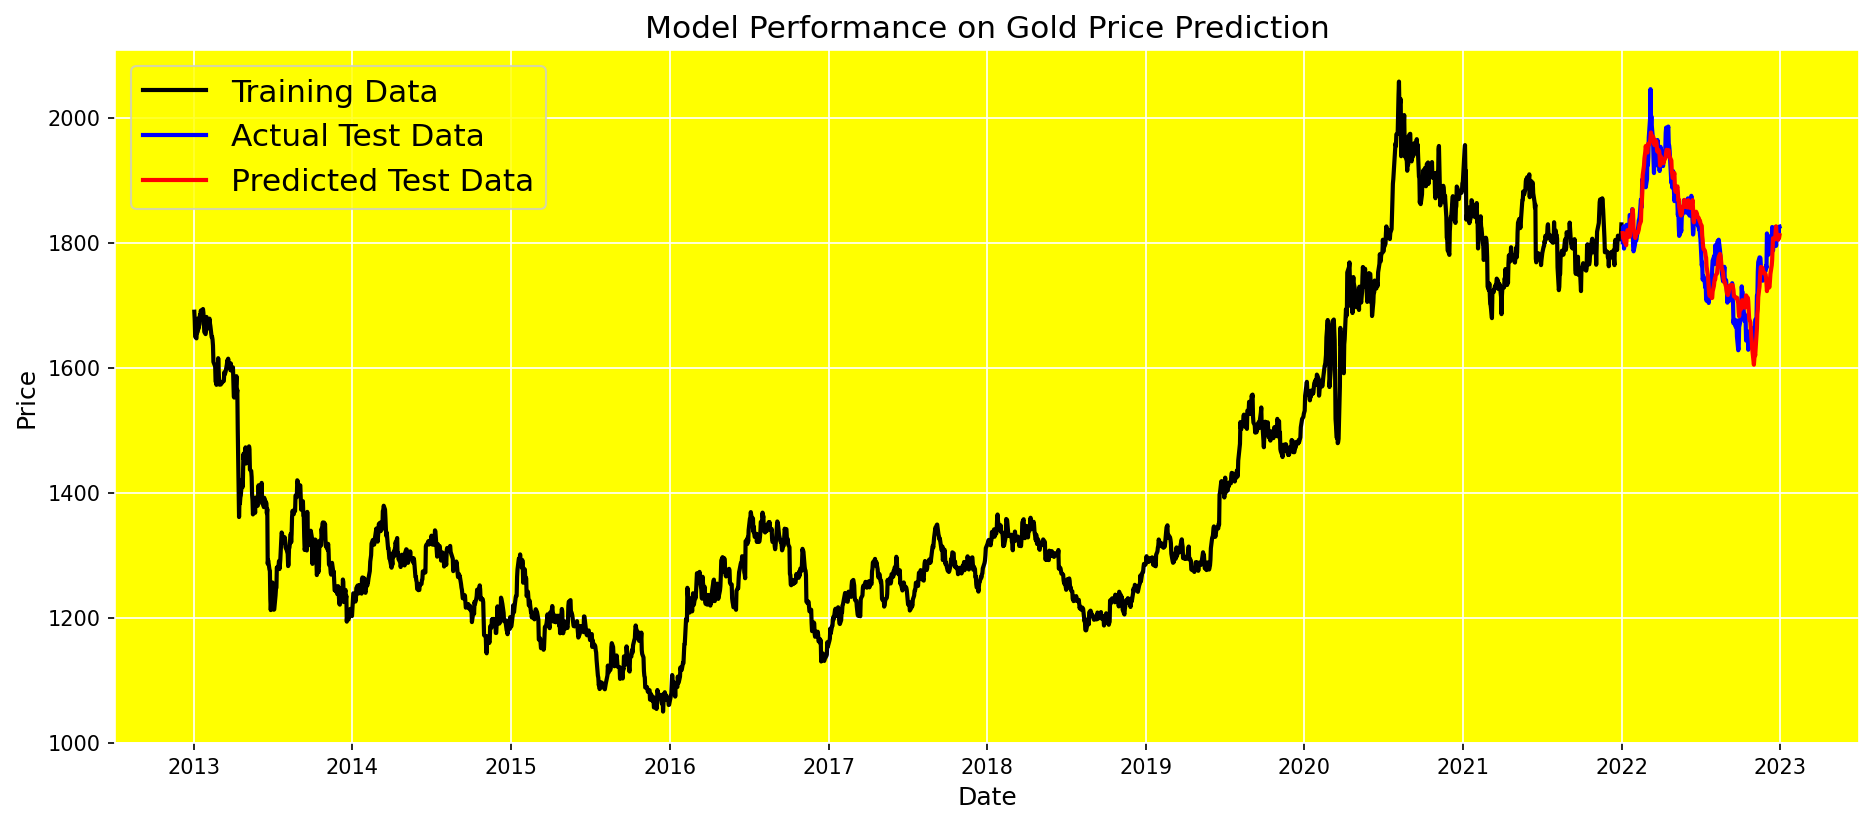

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM

# Step 1: Importing Libraries

# Step 2: Reading Dataset
df = pd.read_csv('/kaggle/input/gold-price-10-years-20132023/Gold Price (2013-2023).csv')

# Step 3: Dataset Overview
df.info()

# Step 4: Data Preparation
# Step 4.1: Feature Subset Selection
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

# Step 4.2: Transforming Data
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove ',' and convert numerical columns to float
numerical_cols = df.columns.drop(['Date'])  # Get all columns except 'Date'
df[numerical_cols] = df[numerical_cols].replace({',': ''}, regex=True)
df[numerical_cols] = df[numerical_cols].astype('float64')

# Step 4.3: Checking Duplicates
df.duplicated().sum()

# Step 4.4: Checking Missing Values
df.isnull().sum().sum()

# Step 5: Visualizing Gold Price History Data
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# Step 6: Splitting Data to Training & Test Sets
test_size = df[df.Date.dt.year==2022].shape[0]

# Step 7: Data Scaling
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

# Step 8: Restructure Data & Create Sliding Window
window_size = 60

train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Step 9: Converting Data to Numpy Arrays
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

# Step 10: Creating an LSTM Network
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

# Step 11: Model Evaluation
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

# Step 12: Visualizing Results
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()
